Load up experiment & annotations

In [1]:
import pandas as pd
import numpy as np
from data_reading.phyphox import read_experiment
from preprocessing._interpolation import align_data
from file_handling import get_sub_directories

experiment_dir_path = "../../data/phyphox/short recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)

sample_rate = 50
chunks = {"right": [], "left": []}
y_columns = ["start", "end", "label", "hand"]
y = pd.DataFrame(columns=y_columns)
#del experiment_dirs[1]
for dir in experiment_dirs:
    offsets = {}
    with open(dir + "/offset.txt") as f:
        for line in f:
           (key, val) = line.split(": ")
           offsets[key] = val

    data_frames = read_experiment(dir, offsets=offsets)
    data_frames = {key : align_data(data_frame, listening_rate=1000/sample_rate, reference_sensor=None) for key, data_frame in data_frames.items()}

    y_user = pd.read_csv(dir + "/annotations.tsv", delimiter="\t", header=None)
    hands = pd.read_csv(dir + "/hands.tsv", delimiter="\t", header=None)
    y_user = y_user.iloc[:, [3,5,8]]
    hands = hands.iloc[:, [8]]
    y_user = pd.concat([y_user, hands], axis=1)
    y_user.columns = y_columns
    y = pd.concat([y, y_user], axis=0)

    # iterate over the annotations and split the timeseries in chunks
    for key, df in data_frames.items():
        chunks[key] += [df.iloc[int(annotation["start"]*sample_rate):int(annotation["end"]*sample_rate)] for i, annotation in y_user.iterrows()]

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


Preprocess data

In [2]:
# append the activity label (as int) and the action id to the dataframe
# we need to do this to be able to extract time series features later

labels = y.loc[:, "label"].unique()
label_ids = { l: i for l,i in zip(labels, range(0,len(labels))) }

# list of tuples (left chunk, right chunk)
chunks_two_handed = []
# list of chunks
chunks_one_handed = []

y = y.replace(label_ids)


for i, cl in zip(range(len(y)), y.iterrows()):
    label_id = int(cl[1]["label"])
    action_id = i
    two_handed_chunk = []
    for hand, chunk_list in chunks.items():
        c = chunk_list[i]
        chunk_hand = cl[1]["hand"]
        #if chunk_hand == "both":
        #c["activity"] = label_id
        #TODO for 2 phase classification: modify the label list
        #else:
             # use an id that's not yet used for another activity to label "single handed" activities
        #    c["activity"] = len(y)
        #c["activity"] = label_id
        c["action_id"] = action_id
        two_handed_chunk.append(c)
        if chunk_hand == hand:
            #c["activity"] = label_id
            chunks_one_handed.append(c)
    left_chunk = two_handed_chunk[0].reset_index()
    right_chunk = two_handed_chunk[1].reset_index(drop=True)
    right_chunk.drop(columns=["action_id"], inplace=True)
    right_chunk.columns = [str(col) + '_right' for col in right_chunk.columns]
    two_handed_chunk = pd.concat([left_chunk, right_chunk], axis=1)
    two_handed_chunk.set_index('index', inplace=True)
    chunks_two_handed.append(two_handed_chunk)

/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Feature extraction for 2 handed activities

In [3]:
pd.concat(chunks_two_handed).reset_index(drop=True)

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
0,-0.673307,1.612486,1.078540,-0.307789,-0.325166,-0.076462,1.874447,3.936874,8.955659,0,-29.846316,27.356560,-3.756765,-1.423801,0.197827,1.223939,1.094288,-10.033983,0.717820
1,0.089392,2.515870,1.111413,-0.360312,-0.290280,-0.074215,1.809394,4.041767,8.994166,0,-39.630793,27.025994,-13.982571,-1.404334,-0.079633,1.163854,2.105665,-9.698308,1.306935
2,1.572597,1.974343,3.998343,-0.358180,-0.173422,-0.088561,1.792549,3.607955,9.116899,0,-49.666327,21.061149,-17.881124,-1.434432,-0.417207,1.115768,2.170279,-9.489603,1.900058
3,3.502345,0.862936,3.771591,-0.363523,-0.170327,-0.078516,1.775054,3.369002,8.896913,0,-58.372896,22.169456,-20.310171,-1.424750,-0.405516,1.148696,1.760429,-9.200116,1.758185
4,3.596560,-1.435948,1.145346,-0.384196,-0.202021,-0.080676,1.699980,3.561380,8.893374,0,-54.498762,16.444340,-24.436021,-1.401236,0.037968,1.025257,1.665103,-9.057712,1.093284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47154,-1.332291,-3.848507,0.274923,0.372370,0.774460,0.516166,3.891755,6.484077,0.214454,198,2.565735,-2.702048,-0.791368,-1.401019,0.476139,0.360373,-1.173825,5.436019,2.058898
47155,-1.376615,-3.267903,0.056250,0.372486,0.859027,0.369443,4.064822,6.682590,0.388434,198,2.489493,-2.486026,-0.699859,-1.365755,0.922626,0.641262,-1.474930,5.473213,1.974482
47156,-1.322395,-2.764954,-0.177624,0.342807,0.949685,0.216374,4.221614,6.880355,0.517930,198,2.084892,-2.247879,-0.626394,-1.324714,1.414125,0.898830,-1.645833,5.500366,2.010542
47157,-1.189850,-2.350704,-0.338179,0.313310,1.028964,0.049876,4.391580,7.050979,0.489979,198,1.687402,-1.933984,-0.528050,-1.259790,1.863392,1.137072,-1.611798,5.612191,2.206535


In [4]:
%load_ext autoreload
%autoreload 2

labels = y.loc[:, "label"].squeeze()
from features._timeseries_feature_extraction import extract_timeseries_features
features_two_handed = extract_timeseries_features(pd.concat(chunks_two_handed).reset_index(drop=True))

Feature Extraction: 100%|██████████| 20/20 [05:07<00:00, 15.36s/it]


In [5]:

features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

variable,acceleration x__abs_energy,acceleration x__absolute_sum_of_changes,"acceleration x__agg_autocorrelation__f_agg_""mean""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""median""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""var""__maxlag_40","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",...,linear_acceleration z_right__symmetry_looking__r_0.9500000000000001,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_1,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_2,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_3,linear_acceleration z_right__value_count__value_-1,linear_acceleration z_right__value_count__value_0,linear_acceleration z_right__value_count__value_1,linear_acceleration z_right__variance,linear_acceleration z_right__variance_larger_than_standard_deviation,linear_acceleration z_right__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
0,152.362043,5.716829,-0.204547,-0.264752,0.160540,2.039521,1.603603,1.268438,0.074262,1.737264,...,1.0,347.499325,2077.840613,3161.051309,0.0,0.0,0.0,143.060915,1.0,-0.729506
1,5816.226167,69.420695,0.164614,0.180835,0.164279,6.047700,5.147875,3.815960,0.773449,5.708267,...,1.0,0.247599,0.896086,1.188017,0.0,0.0,0.0,2.627204,1.0,-4.796790
2,518.147057,30.058553,-0.088996,-0.161149,0.134872,3.086037,2.006977,1.123898,0.452958,2.804729,...,1.0,0.242447,0.334323,0.386098,0.0,0.0,0.0,0.828458,0.0,-2.411575
3,3387.762553,123.382555,-0.012698,-0.062500,0.057817,4.619957,2.207716,0.931568,2.584999,3.410621,...,1.0,-0.010524,-0.038137,-0.082098,0.0,0.0,0.0,1.140251,1.0,-9.194041
4,2835.841612,105.832075,0.222970,0.244265,0.035229,9.650999,5.708025,2.763782,4.055142,8.102911,...,1.0,0.054650,0.072999,0.080600,0.0,0.0,0.0,0.346956,0.0,5.285892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1304.263346,13.441939,-0.118184,-0.308109,0.234830,6.737088,6.021765,5.246862,0.274544,6.507615,...,1.0,-0.082369,-0.137841,-0.149862,0.0,0.0,0.0,0.460583,0.0,-130.904668
195,2787.969655,25.133046,-0.167563,-0.281226,0.282601,7.028043,5.852920,4.427565,0.842505,6.273651,...,1.0,0.125434,0.491858,1.144495,0.0,0.0,0.0,1.728707,1.0,24.693562
196,1860.748151,18.830506,-0.058219,-0.111479,0.068905,6.595280,5.304842,4.266154,0.891567,6.069896,...,1.0,-0.118112,-0.326745,-0.361511,0.0,0.0,0.0,0.565488,0.0,-14.852349


Feature selection

In [6]:
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, labels.to_numpy())
X_two_handed_selected


variable,"linear_acceleration z__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""","linear_acceleration z__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","linear_acceleration z_right__agg_autocorrelation__f_agg_""mean""__maxlag_40","linear_acceleration z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0",linear_acceleration z__mean_abs_change,"linear_acceleration z__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.0","linear_acceleration z__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","linear_acceleration z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0","linear_acceleration z__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.0","linear_acceleration z__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0",...,gyroscope z__large_standard_deviation__r_0.2,gyroscope x__large_standard_deviation__r_0.15000000000000002,gyroscope x__symmetry_looking__r_0.05,gyroscope x_right__large_standard_deviation__r_0.1,gyroscope y_right__large_standard_deviation__r_0.1,gyroscope y__variance_larger_than_standard_deviation,linear_acceleration x__large_standard_deviation__r_0.30000000000000004,linear_acceleration x__large_standard_deviation__r_0.15000000000000002,acceleration z__large_standard_deviation__r_0.15000000000000002,gyroscope z_right__large_standard_deviation__r_0.1
id,,,,,,,,,,,,,,,,,,,,,
0,0.181923,2.015898,-0.024020,1.123940,1.123940,0.402791,2.133104,0.746330,1.479272,2.087551,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,0.055107,0.101948,0.068042,0.862284,0.862284,0.416163,2.331122,0.752368,0.835909,0.798750,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2,0.173323,0.350281,0.066103,0.733112,0.733112,0.808633,1.715398,0.771217,1.356078,0.992030,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,0.044142,0.154401,-0.077899,0.901261,0.901261,0.533942,1.783000,1.135304,1.079704,0.834038,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.044277,0.149524,0.034120,0.644981,0.644981,0.294320,0.883340,0.481948,0.492255,0.647002,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.009640,0.096184,0.001683,0.254058,0.254058,0.046934,0.114229,0.291154,0.101550,0.102018,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
195,0.181603,0.502644,0.012989,0.703324,0.703324,0.175360,1.463504,0.221073,0.372077,0.343535,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
196,0.012416,0.096407,0.011796,0.279500,0.279500,0.106309,0.167552,0.454023,0.163178,0.147190,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [9]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

array([[-0.02674668,  1.25551555,  1.25551555, ...,  0.53279543,
         0.42132504,  0.16054032],
       [ 0.92093556,  0.65087664,  0.65087664, ..., -1.87689298,
         0.42132504,  0.16054032],
       [ 0.90098005,  0.3523856 ,  0.3523856 , ...,  0.53279543,
         0.42132504,  0.16054032],
       ...,
       [ 0.34194311, -0.69582735, -0.69582735, ...,  0.53279543,
         0.42132504,  0.16054032],
       [-0.39136268, -0.25491622, -0.25491622, ...,  0.53279543,
         0.42132504,  0.16054032],
       [ 0.12693697, -0.64829404, -0.64829404, ...,  0.53279543,
         0.42132504,  0.16054032]])

Train models and score results


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Two handed classification
Logistic Regression: 0.75 +/- 0.12
LDA: 0.71 +/- 0.17
LinearSVC: 0.73 +/- 0.14
CART: 0.44 +/- 0.07
NB: 0.40 +/- 0.11


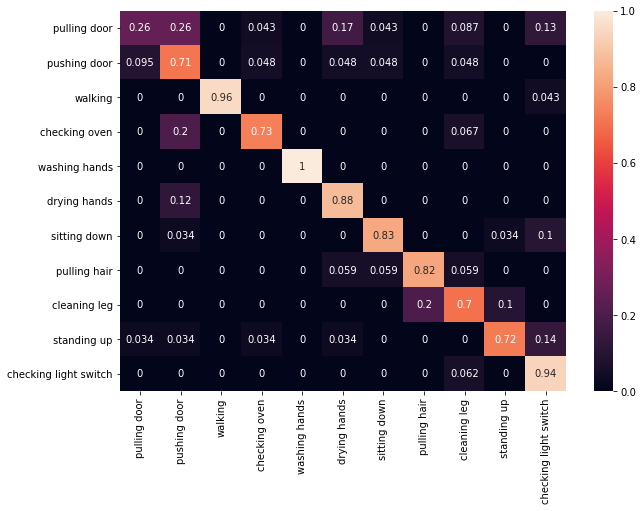

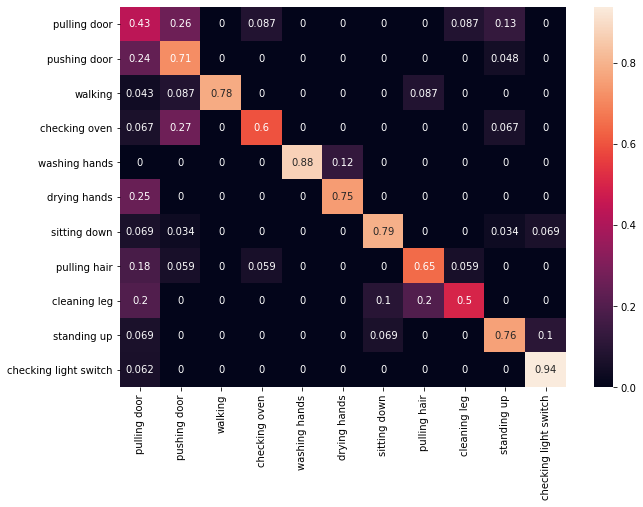

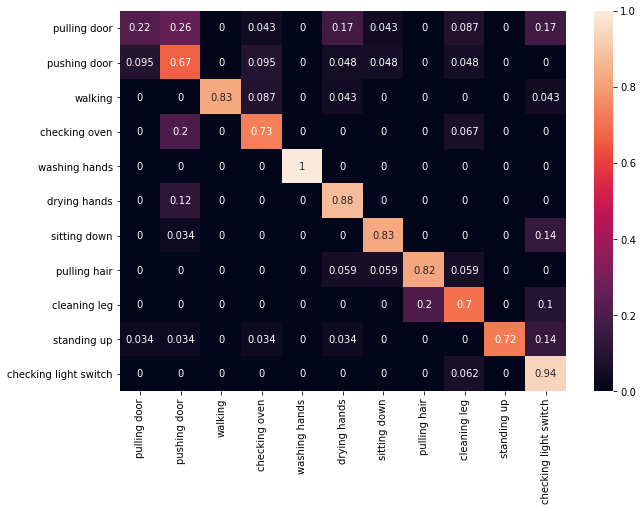

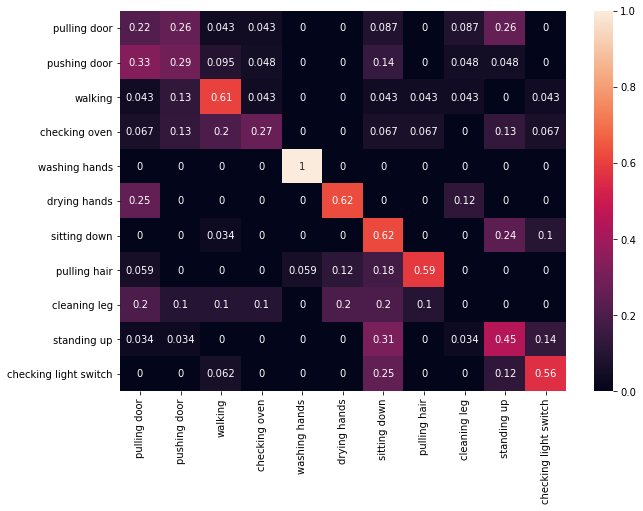

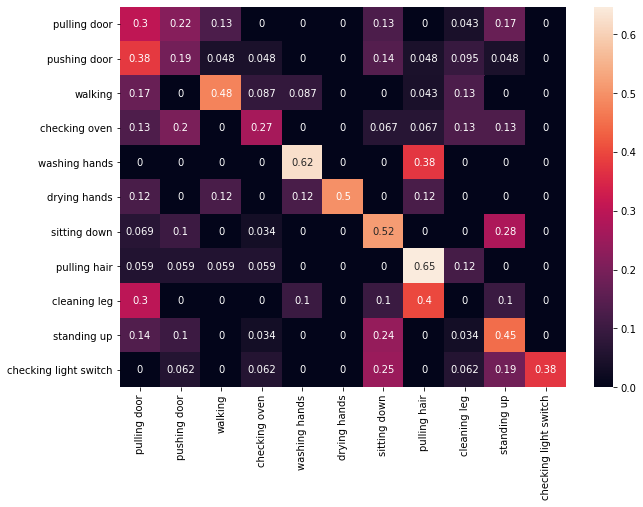

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

models = [('Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr')), ('LDA', LinearDiscriminantAnalysis()), ('LinearSVC', LinearSVC()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB())]


def classify_all(X, y):
    for name, model in models:
        scores = cross_val_score(model, X, y, cv=8)
        print('{}: {:1.2f} +/- {:1.2f}'.format(name, scores.mean(), scores.std()))

        # confusion matrix
        y_pred = cross_val_predict(model, X, y, cv=8)
        conf_mat = confusion_matrix(y, y_pred)
        #print(conf_mat)
        df_cm = pd.DataFrame(conf_mat, index = label_ids.keys(),
                  columns = label_ids.keys())
        df_cm["sum"] = df_cm.sum(axis=1)
        df_cm = df_cm.loc[:,label_ids.keys()].div(df_cm["sum"], axis=0)
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        plt.show()


print("Two handed classification")
classify_all(X, labels)

In [12]:
labels.value_counts()

9     29
6     29
2     23
0     23
1     21
7     17
10    16
3     15
8     10
5      8
4      8
Name: label, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_two_handed,labels, test_size=0.2)
m = models[0][1]
m.fit(X_train, y_train)
m.score(X_test, y_test)

0.575

In [14]:
label_ids

{'pulling door': 0,
 'pushing door': 1,
 'walking': 2,
 'checking oven': 3,
 'washing hands': 4,
 'drying hands': 5,
 'sitting down': 6,
 'pulling hair': 7,
 'cleaning leg': 8,
 'standing up': 9,
 'checking light switch': 10}